# Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import scipy.io

keras = tf.keras

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00580/hungary_chickenpox.zip"
# download and unzip required file
import requests, zipfile, io
r = requests.get(URL)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/chickenpox")

# read the files
train_df = pd.read_csv('/content/chickenpox/hungary_chickenpox.csv')
test_df = pd.read_csv('/content/chickenpox/hungary_county_edges.csv')

train_df['TOTAL'] = train_df.iloc[:,1:].sum(axis=1)


# Visual 

In [ ]:
# adding required functions

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=5)
    plt.grid(True)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast    

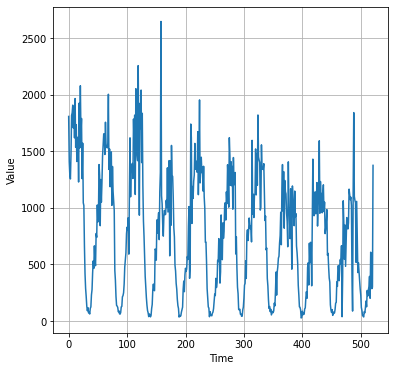

In [ ]:
# discarded the date object with integers
# done to find where to split data 
time = np.arange(0,522) 
series = train_df['TOTAL']
plt.figure(figsize=(6,6))
plot_series(time,series)
plt.show()

In [ ]:
# splitting series into training and validation split since data is less 
time_split = 400
time_train = time[:time_split]
x_train = series[:time_split]
time_val = time[time_split:]
x_val = series[time_split:]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size=50)

# seq2seq stateless rnn with cnn

model = keras.models.Sequential([
            keras.layers.Conv1D(filters=32,kernel_size=5,
                                strides=1,padding = "causal",
                                activation="relu",input_shape=[None,1]),
            keras.layers.LSTM(32,return_sequences=True),
            keras.layers.LSTM(32,return_sequences=True),
            keras.layers.Dense(1),
            keras.layers.Lambda(lambda x: x*200.0)                    
])



lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(optimizer=optimizer,
              loss=keras.losses.Huber(),
              metrics=["mae"])
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

(1e-09, 0.1, 0.0, 1000.0)

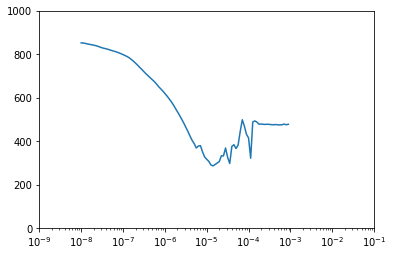

In [ ]:
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-9,1e-1,0,1000])

learning rate chosen: 1e-6

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train,window_size,batch_size=57)
val_set = seq2seq_window_dataset(x_val,window_size,57)

# seq2seq stateless rnn with cnn

model = keras.models.Sequential([
            keras.layers.Conv1D(filters=32,kernel_size=5,
                                strides=1,padding = "causal",
                                activation="relu",input_shape=[None,1]),
            keras.layers.LSTM(32,return_sequences=True),
            keras.layers.LSTM(32,return_sequences=True),
            keras.layers.Dense(1),
            keras.layers.Lambda(lambda x: x*200.0)                    
])


early_stopping = keras.callbacks.EarlyStopping(patience=65)
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)

model.compile(optimizer=optimizer,
              loss=keras.losses.Huber(),
              metrics=["mae"])

history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=400,
                    callbacks=[early_stopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


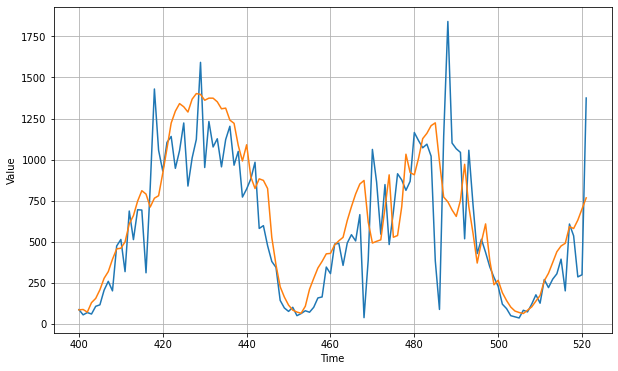

In [ ]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[time_split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_val,rnn_forecast).numpy()

189.526

In [ ]:
model.save_weights('./chickenpox/my_checkpoint')

#Fully Covolutional Network

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 32
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=50)
# using wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, callbacks=[lr_schedule])

(1e-08, 0.01, 0.0, 1000.0)

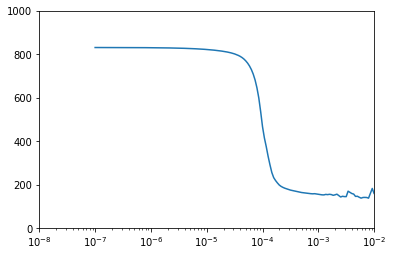

In [ ]:
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 1000])

1e-5 looks like good learning rate

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 32
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=50)
val_set = seq2seq_window_dataset(x_val,window_size,batch_size=50)

# using wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

early_stopping = keras.callbacks.EarlyStopping(patience=40)

optimizer = keras.optimizers.Adam(lr=6e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=400, 
                    callbacks=[early_stopping])

Epoch 1/400
8/8 [==============================] - 2s 62ms/step - loss: 789.0339 - mae: 789.5339 - val_loss: 638.2498 - val_mae: 638.7498
Epoch 2/400
8/8 [==============================] - 0s 14ms/step - loss: 797.8301 - mae: 798.3300 - val_loss: 635.6140 - val_mae: 636.1140
Epoch 3/400
8/8 [==============================] - 0s 14ms/step - loss: 796.6606 - mae: 797.1605 - val_loss: 632.7221 - val_mae: 633.2220
Epoch 4/400
8/8 [==============================] - 0s 14ms/step - loss: 784.1325 - mae: 784.6323 - val_loss: 629.5801 - val_mae: 630.0801
Epoch 5/400
8/8 [==============================] - 0s 14ms/step - loss: 780.8626 - mae: 781.3623 - val_loss: 626.1176 - val_mae: 626.6174
Epoch 6/400
8/8 [==============================] - 0s 14ms/step - loss: 796.0647 - mae: 796.5645 - val_loss: 622.2732 - val_mae: 622.7728
Epoch 7/400
8/8 [==============================] - 0s 14ms/step - loss: 769.0699 - mae: 769.5697 - val_loss: 618.0243 - val_mae: 618.5242
Epoch 8/400
8/8 [=================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


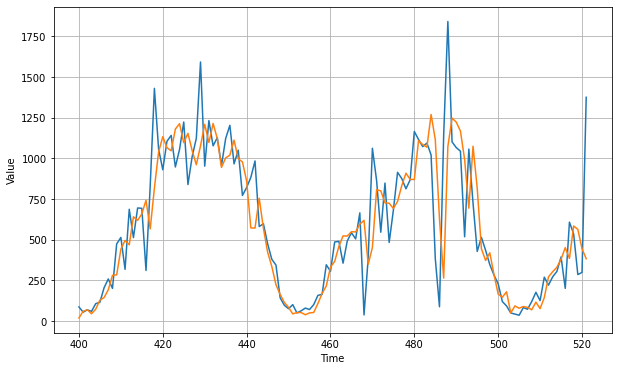

In [ ]:
cnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[time_split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, cnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_val,cnn_forecast).numpy()

150.61058

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 32
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=50)
val_set = seq2seq_window_dataset(x_val,window_size,batch_size=50)

# using wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

early_stopping = keras.callbacks.EarlyStopping(patience=20)

optimizer = keras.optimizers.Adam(lr=8e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=400, 
                    callbacks=[early_stopping])

Epoch 1/400
8/8 [==============================] - 2s 61ms/step - loss: 788.8030 - mae: 789.3030 - val_loss: 637.3967 - val_mae: 637.8967
Epoch 2/400
8/8 [==============================] - 0s 14ms/step - loss: 796.5219 - mae: 797.0217 - val_loss: 633.7364 - val_mae: 634.2363
Epoch 3/400
8/8 [==============================] - 0s 15ms/step - loss: 794.0925 - mae: 794.5923 - val_loss: 629.6771 - val_mae: 630.1771
Epoch 4/400
8/8 [==============================] - 0s 14ms/step - loss: 780.1431 - mae: 780.6429 - val_loss: 625.1141 - val_mae: 625.6138
Epoch 5/400
8/8 [==============================] - 0s 14ms/step - loss: 775.2230 - mae: 775.7227 - val_loss: 619.9354 - val_mae: 620.4349
Epoch 6/400
8/8 [==============================] - 0s 14ms/step - loss: 788.3565 - mae: 788.8562 - val_loss: 614.0671 - val_mae: 614.5670
Epoch 7/400
8/8 [==============================] - 0s 14ms/step - loss: 759.3180 - mae: 759.8178 - val_loss: 607.5087 - val_mae: 608.0081
Epoch 8/400
8/8 [=================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


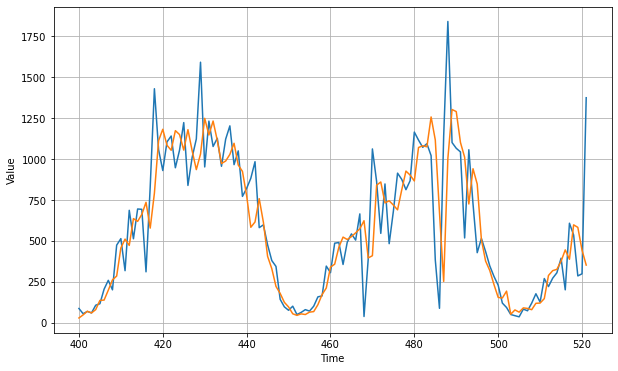

In [ ]:
cnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[time_split - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, cnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_val,cnn_forecast).numpy()

153.24796